# Select Data, IRT model, and Device


In [1]:
# 0 -> bone
# 1 (others) -> brain

#DATA = 0 
DATA = 1


In [2]:
# 0 -> 1PL-IRT
# 1 (others) -> 2PL-IRT 

#MODEL = 0
MODEL = 1


In [3]:
# 0 -> CPU
# 1 -> GPU
# 2 -> GPU vectorized

DEVICE = 0
#DEVICE = 1
#DEVICE = 2


In [4]:
if DEVICE == 2:
    chain_method = 'vectorized'
else:
    chain_method = 'parallel'


# Prepare

In [5]:
! cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs mmio_stale_data retbleed
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtua

In [6]:
#! pip install -q "jax[cuda11_cudnn805]"==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
! pip install -q numpyro==0.10.1 arviz==0.12.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.7/292.7 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.1.2 requires arviz>=0.13.0, but you have arviz 0.12.1 which is incompatible.


In [7]:
! pip list | grep jax
! pip list | grep numpyro

jax                           0.4.6
jaxlib                        0.4.6+cuda11.cudnn86
numpyro                       0.10.1


In [8]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
import numpyro
import numpyro.distributions as dist
import arviz as az
import jax
import jax.numpy as jnp

In [10]:
if DEVICE == 0:
    numpyro.set_platform('cpu')
    numpyro.set_host_device_count(6)
else:
    numpyro.set_platform('gpu')
    n = jax.device_count()
    print("number of GPU", n)
    if n < 1:
        raise Exception("no GPU")
    else:
        ! nvidia-smi


## Import & Check Data

In [11]:
if DATA == 0:
    ! wget https://filedn.com/lpAczQGgeBjkX6l7SpI5JJy/__ws/stan_irt_nrm_rad/bone_meta_accuracy_for_irt___2017_0608.csv -O accuracy_for_irt___2017_0608.csv
else:
    ! wget https://filedn.com/lpAczQGgeBjkX6l7SpI5JJy/__ws/stan_irt_nrm_rad/brain_stroke_accuracy_for_irt___2018_1029.csv -O accuracy_for_irt___2017_0608.csv

df_ = pd.read_csv('./accuracy_for_irt___2017_0608.csv')

if DATA == 0:
    df = df_.iloc[0:60,2:9]
else:
    df = df_.iloc[0:42,2:16]

--2023-03-24 01:32:49--  https://filedn.com/lpAczQGgeBjkX6l7SpI5JJy/__ws/stan_irt_nrm_rad/brain_stroke_accuracy_for_irt___2018_1029.csv
Resolving filedn.com (filedn.com)... 74.120.9.25
Connecting to filedn.com (filedn.com)|74.120.9.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3700 (3.6K) [text/csv]
Saving to: ‘accuracy_for_irt___2017_0608.csv’

accuracy_for_irt___ 100%[===================>]   3.61K  --.-KB/s    in 0s      

2023-03-24 01:32:49 (730 MB/s) - ‘accuracy_for_irt___2017_0608.csv’ saved [3700/3700]



In [12]:
df.head()

,Dr.A,Dr.B,Dr.C,Dr.D,Dr.E,Dr.F,Dr.G,Dr.H,Dr.I,Dr.J,Dr.K,Dr.L,Dr.M,Dr.N
0,1,1,1,1,1,1,1,1,1,0,1,1,0,1
1,1,1,1,1,1,1,1,0,1,1,0,1,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [13]:
df.describe()

,Dr.A,Dr.B,Dr.C,Dr.D,Dr.E,Dr.F,Dr.G,Dr.H,Dr.I,Dr.J,Dr.K,Dr.L,Dr.M,Dr.N
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,0.761905,0.690476,0.761905,0.690476,0.714286,0.714286,0.476190,0.380952,0.761905,0.666667,0.761905,0.761905,0.595238,0.619048
std,0.431081,0.467901,0.431081,0.467901,0.457230,0.457230,0.505487,0.491507,0.431081,0.477119,0.431081,0.431081,0.496796,0.491507
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
if DATA == 0:
    print(0, (df["Dr1."]==0).sum())
    print(1, (df["Dr1."]==1).sum())
else:
    print(0, (df["Dr.A"]==0).sum())
    print(1, (df["Dr.A"]==1).sum())


# 0 -> inaccurate diagnosis 
# 1 -> accurate diagnosis


0 10
1 32


## Convert DataFrame

In [15]:
rad_resp = df.copy()

In [16]:
num_case = rad_resp.shape[0]
num_rad = rad_resp.shape[1]


In [17]:
print(num_case)
print(num_rad)

42
14


In [18]:
rad_resp

,Dr.A,Dr.B,Dr.C,Dr.D,Dr.E,Dr.F,Dr.G,Dr.H,Dr.I,Dr.J,Dr.K,Dr.L,Dr.M,Dr.N
0,1,1,1,1,1,1,1,1,1,0,1,1,0,1
1,1,1,1,1,1,1,1,0,1,1,0,1,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,0,0,0,0,1,0,0,0,0,0,0,0,1
7,1,0,1,1,1,1,1,1,1,0,0,1,1,1
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,1,1,1,1,1,0,1,1,1,1,1,1


In [19]:
y = rad_resp.to_numpy()

# Run Numpyro

## Define Model

In [20]:
def model_1pl(y=None, num_cases=0, num_doctors=0):
    with numpyro.plate('doctor', num_doctors):
      theta = numpyro.sample('theta', dist.Normal(0, 2))

    with numpyro.plate('case', num_cases, dim=-2):
        beta = numpyro.sample('beta', dist.Normal(0, 2))
        with numpyro.plate('doctor', num_doctors):
            mu = theta - beta
            numpyro.sample('obs', dist.Bernoulli(logits=mu), obs=y)

In [21]:
def model_2pl(y=None, num_cases=0, num_doctors=0):
    with numpyro.plate('doctor', num_doctors):
      theta = numpyro.sample('theta', dist.Normal(0, 2))

    with numpyro.plate('case', num_cases, dim=-2):
        beta = numpyro.sample('beta', dist.Normal(0, 2))
        log_d = numpyro.sample('log_d', dist.Normal(0.5, 1))
        with numpyro.plate('doctor', num_doctors):
            mu = jnp.exp(log_d)*(theta - beta)
            numpyro.sample('obs', dist.Bernoulli(logits=mu), obs=y)

In [22]:
model = model_1pl if MODEL == 0 else model_2pl

In [23]:
nuts = numpyro.infer.NUTS(model)

In [24]:
print(chain_method)

parallel


In [25]:
mcmc = numpyro.infer.MCMC(nuts, num_warmup=2000, num_samples=8000, num_chains=6, chain_method=chain_method)
#mcmc = numpyro.infer.MCMC(nuts, num_warmup=2000, num_samples=8000, chain_method=chain_method)

mcmc.run(jax.random.PRNGKey(0), y=y, num_cases=num_case, num_doctors=num_rad)
mcmc_samples = mcmc.get_samples()

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

## Check Results

In [26]:
idata = az.from_numpyro(mcmc)
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

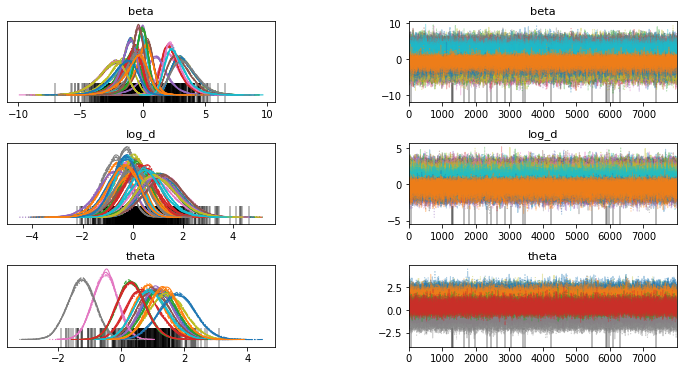

In [27]:
axes = az.plot_trace(idata)
plt.gcf().subplots_adjust(wspace=0.5, hspace=0.5)

In [28]:
az.summary(idata, var_names=['theta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],1.185,0.532,0.192,2.179,0.004,0.003,19764.0,28817.0,1.0
theta[1],0.903,0.488,-0.006,1.826,0.004,0.003,18047.0,27053.0,1.0
theta[2],1.255,0.516,0.294,2.221,0.004,0.003,19766.0,29393.0,1.0
theta[3],0.704,0.533,-0.256,1.740,0.004,0.003,16619.0,26149.0,1.0
theta[4],1.138,0.500,0.197,2.071,0.004,0.003,18682.0,27333.0,1.0
theta[5],1.044,0.520,0.078,2.027,0.004,0.003,18070.0,28157.0,1.0
theta[6],-0.507,0.394,-1.234,0.247,0.003,0.002,13461.0,22824.0,1.0
theta[7],-1.269,0.432,-2.088,-0.469,0.003,0.002,16243.0,27537.0,1.0
theta[8],1.457,0.567,0.409,2.539,0.004,0.003,19735.0,29544.0,1.0
theta[9],0.945,0.531,-0.044,1.950,0.004,0.003,17435.0,26401.0,1.0


In [29]:
az.summary(idata, var_names=['beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",-1.574,1.120,-3.700,0.368,0.006,0.005,36270.0,27140.0,1.0
"beta[1, 0]",-0.977,1.044,-3.003,0.820,0.006,0.005,30714.0,27043.0,1.0
"beta[2, 0]",3.382,1.028,1.617,5.313,0.006,0.005,28174.0,26178.0,1.0
"beta[3, 0]",-2.609,1.142,-4.781,-0.652,0.006,0.005,36272.0,28831.0,1.0
"beta[4, 0]",-2.611,1.145,-4.789,-0.665,0.006,0.005,38177.0,27828.0,1.0
"beta[5, 0]",-2.613,1.139,-4.800,-0.670,0.006,0.005,37358.0,29065.0,1.0
"beta[6, 0]",2.255,0.986,0.505,4.184,0.006,0.004,28863.0,26837.0,1.0
"beta[7, 0]",-1.400,1.240,-3.857,0.762,0.006,0.005,42691.0,30188.0,1.0
"beta[8, 0]",3.376,1.022,1.635,5.325,0.006,0.004,29184.0,28737.0,1.0
"beta[9, 0]",-1.216,0.784,-2.706,0.108,0.006,0.004,21337.0,21846.0,1.0


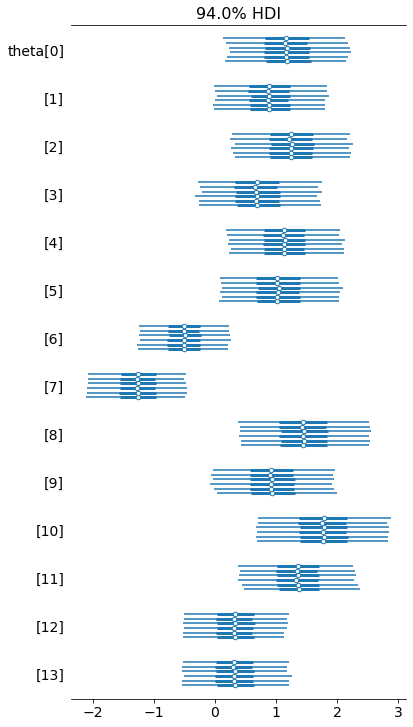

In [30]:
axes = az.plot_forest(idata, var_names=['theta'])